In [1]:
using LinearAlgebra
using TrajectoryOptimization
using Plots

┌ Info: Precompiling TrajectoryOptimization [c79d492b-0548-5874-b488-5a62c1d9d0ca]
└ @ Base loading.jl:1273
┌ Warning: Package TrajectoryOptimization does not have DifferentialEquations in its dependencies:
│ - If you have TrajectoryOptimization checked out for development and have
│   added DifferentialEquations as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with TrajectoryOptimization
└ Loading DifferentialEquations into TrajectoryOptimization from project dependency, future warnings for TrajectoryOptimization are suppressed.


In [2]:
#Pauli spin matrices
i2 = [0 -1; 1 0] #2x2 unit imaginary matrix
Sx = [zeros(2,2) I; I zeros(2,2)]
Sy = [zeros(2,2) -i2; i2 zeros(2,2)]
Sz = [I zeros(2,2); zeros(2,2) -I]
iSx = [zeros(2,2) i2; i2 zeros(2,2)]
iSy = [zeros(2,2) I; -I zeros(2,2)]
iSz = [i2 zeros(2,2); zeros(2,2) -i2];

In [20]:
function qubit_dynamics!(ẋ,x,u̇)
      u = x[5]
      ẋ .= [(-iSx - u.*iSz)*x[1:4]; u̇]
end

qubit_dynamics! (generic function with 1 method)

In [21]:
n = 5 #state dimension
m = 1 #inut dimension
model = Model(qubit_dynamics!,n,m)
model_d = rk4(model);

In [22]:
dt = 0.01 #time step
N = 101 #number of knot points

x0 = [1.0, 0, 0, 0, 0] #initial state
xf = [1/sqrt(2), 0, 1/sqrt(2), 0, 0] #desired final state

u0 = [randn(m) for k = 1:N-1]; #random initial guess for control inputs

#Set up quadratic objective function
Q = 1.0*Diagonal(I,n)
R = 1.0*Diagonal(I,m)
Qf = 10.0*Diagonal(I,n)
obj = LQRObjective(Q,R,Qf,xf,N);

In [28]:
#Set up input constriants
bnd = BoundConstraint(n,m,x_min=[-Inf, -Inf, -Inf, -Inf, -3], x_max=[Inf, Inf, Inf, Inf, 3])
goal = goal_constraint(xf) # terminal constraint

constraints = Constraints(N) # define constraints at each time step
for k = 1:N-1
    constraints[k] += bnd
end
constraints[N] += goal;

In [29]:
#Set up and solve traj. opt. problem
prob = Problem(model_d, obj, constraints=constraints, x0=x0, xf=xf, N=N, dt=dt)
initial_controls!(prob, u0) #random guess for initial controls
solver = solve!(prob, ALTROSolverOptions{Float64}());

┌ Info: Augmented Lagrangian solve...
└ @ TrajectoryOptimization /Users/zac/.julia/dev/TrajectoryOptimization/src/solvers/altro/altro_methods.jl:25


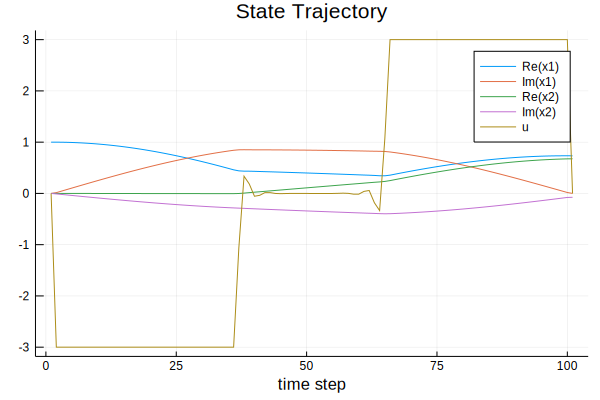

In [30]:
plot(prob.X,xlabel="time step",title="State Trajectory",label=["Re(x1)" "Im(x1)" "Re(x2)" "Im(x2)" "u"])

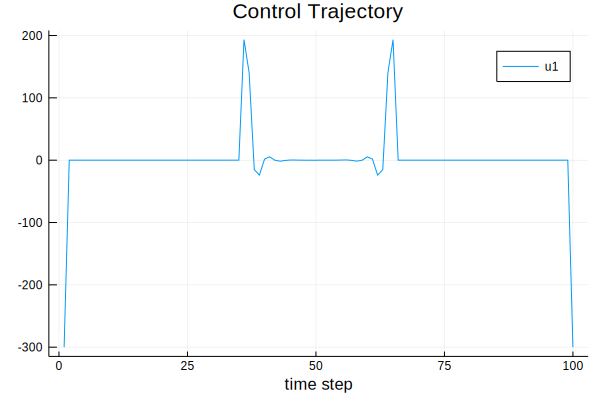

In [31]:
plot(prob.U,xlabel="time step",title="Control Trajectory",label="u1")